In [246]:
!pip install opencv-python

You should consider upgrading via the '/Users/rafaelbardisarodes/opt/anaconda3/bin/python -m pip install --upgrade pip' command.


In [247]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from PIL import Image
import gzip
import os
import cv2
import csv
from os.path import dirname, basename, isfile, join
import glob
import fitz
import re
import json
import matplotlib.pyplot as plt
from matplotlib import pyplot
from scipy.stats import iqr
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, auc, roc_curve, classification_report, confusion_matrix, precision_score, recall_score, precision_recall_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier
import requests


# Const directory locations
CWD = dirname(os.path.realpath("__file__"))
DATA_DIR = f'{CWD}/data'

In [248]:
# color globals
red = "\033[91m"
blue = "\033[94m"
white = "\033[0m"

In [249]:
# read json files from remote and store them locally
suffixes = ["first", "second", "third"]
prefix = "http://schneiderapihack-env.eba-3ais9akk.us-east-2.elasticbeanstalk.com/"

url_list = [f"{prefix}{suffix}" for suffix in suffixes]

train_json_list = [requests.get(url).json() for url in url_list]

for idx, json_data in enumerate(train_json_list):
  with open(f'{DATA_DIR}/train{idx}.json', 'w') as out_file:
    out_file.write(json.dumps(json_data))

In [250]:
def csv_try_parse(file):
    """
    reads a csv with default separator. If it fails, tries with ;
    """
    try:
        return pd.read_csv(file)
    except pd.errors.ParserError:
        return pd.read_csv(file, sep=';')



# split csv files into train and test. Supports multiple test files
csv_files = glob.glob(join(DATA_DIR, "*.csv"))
csv_training_files = [file for file in csv_files if not basename(file).startswith('test')]
csv_test_files = [file for file in csv_files if basename(file).startswith('test')]

pdf_files = glob.glob(join(DATA_DIR, "*.pdf"))
json_files = glob.glob(join(DATA_DIR, "*.json"))

csv_dataframes = [csv_try_parse(file) for file in csv_training_files]
test_dataframes = [csv_try_parse(file) for file in csv_test_files]
json_dataframes = [pd.read_json(file) for file in json_files]

test_dataframe = pd.concat(test_dataframes)

In [251]:
# get list of pdf files
pdf_files = glob.glob(join(DATA_DIR, "*.pdf"))

# hardcoded list of pdf attributes
LIST_ATTRIBUTES = ["nº",
                   "FACILITY NAME",
                   "FacilityInspireID",
                   "COUNTRY",
                   "CONTINENT",
                   "CITY",
                   "EPRTRSectorCode", 
                  "eprtrSectorName",
                   "MainActivityCode",
                   "targetRealase",
                   "pollutant",
                   "emissions",
                   "DAY",
                    "MONTH",
                   "YEAR",
                   "max_wind_speed",
                   "min_wind_speed",
                   "avg_wind_speed",
                   "max_temp",
                   "min_temp",
                  "avg_temp",
                   "DAYS_FOG",
                   "REPORTER NAME",
                   "CITY_ID"]

# escape any regex special characters to filter in later functions
REGEX_LIST_ATTRIBUTES = [re.escape(word) for word in LIST_ATTRIBUTES]

In [252]:
# useful functions for pdf parsing
def remove_trailing_text(text):
    """
    dirty fix to correctly format pdf
    """
    if ' METEOROLOGICAL CONDITIONS' in text:
        return text.split(" ")[0]
    if 'S FOG ' in text:
        return text.split(" ")[-1]
    return text


def remove_trailing_number(text):
    """
    if last word of text is a number, remove it
    """
    text_list = text.split(" ")
    if text_list[-1].isnumeric():
        return " ".join(text_list[:-1])
    return text


def pdf_text_parse(text):
    """
    Parse a report pdf to get its data. Uses dirty fixes for correct formatting
    """
    regex = r'{}'.format("|".join(REGEX_LIST_ATTRIBUTES[::-1]))
    
    # remove punctuation, split and strip text
    text_1 = text.replace(":", "")
    text_2 = text_1.replace("\n", " ")
    regex_text = [r.strip() for r in re.split(regex, text_2)]
    
    # full dirty fixes
    regex_text.remove('REPORT CONTAMINACIÓN')
    return [remove_trailing_text(text) for text in regex_text]


def pdf_parse(pdf, to_list):
    """
    adds contents of pdf to the list
    """
    with fitz.open(file) as pdf:
        for page in pdf:
            list_data.append(pdf_text_parse(page.get_text()))
  

def replace_columns_by(self, df):
    """
    method to rename columns of dataframe by columns of other dataframe
    used to correctly merge two distinctly named dataframes without problems
    """
    merge_dict = {old_idx: new_idx for old_idx, new_idx in zip(self.columns, df.columns)}
    self.rename(columns=merge_dict, inplace = True)
    
#inject method into DataFrame class
pd.DataFrame.replace_columns_by = replace_columns_by

In [253]:
# reads pdf files to list
list_data = []

for file in pdf_files:
    pdf_parse(file, list_data)

# list_data is a list of lists so we can create the dataframe easily
df_pdf = pd.DataFrame(data = list_data, columns=LIST_ATTRIBUTES)

# duplicate reports are useless, will skew the results
df_pdf.drop_duplicates(subset='nº', keep="last", inplace=True)

# fix to remove trailing number in facility names
df_pdf['FACILITY NAME'] = df_pdf['FACILITY NAME'].apply(remove_trailing_number)

In [254]:
# concatenate csv and json dataframes
list_dfs = csv_dataframes + json_dataframes
train_data = pd.concat(list_dfs)
train_data.head()

,countryName,eprtrSectorName,EPRTRAnnexIMainActivityLabel,FacilityInspireID,facilityName,City,targetRelease,pollutant,reportingYear,MONTH,...,min_wind_speed,max_temp,avg_temp,min_temp,DAY WITH FOGS,REPORTER NAME,CITY ID,,EPRTRAnnexIMainActivityCode,EPRTRSectorCode
0,Germany,Mineral industry,Installations for the production of cement cli...,https://registry.gdi-de.org/id/de.ni.mu/062217...,Holcim (Deutschland) GmbH Werk Höver,Sehnde,AIR,Carbon dioxide (CO2),2015,10,...,21.419106,2.864895,4.924169,9.688206,2,Mr. Jacob Ortega,7cdb5e74adcb2ffaa21c1b61395a984f,NaN,NaN,NaN
1,Italy,Mineral industry,Installations for the production of cement cli...,IT.CAED/240602021.FACILITY,Stabilimento di Tavernola Bergamasca,TAVERNOLA BERGAMASCA,AIR,Nitrogen oxides (NOX),2018,9,...,21.756389,5.462839,7.864403,12.023521,1,Ashlee Serrano,cd1dbabbdba230b828c657a9b19a8963,NaN,NaN,NaN
2,Spain,Waste and wastewater management,Landfills (excluding landfills of inert waste ...,ES.CAED/001966000.FACILITY,COMPLEJO MEDIOAMBIENTAL DE ZURITA,PUERTO DEL ROSARIO,AIR,Methane (CH4),2019,2,...,17.103930,1.511201,4.233438,8.632193,2,Vincent Kemp,5011e3fa1436d15b34f1287f312fbada,NaN,NaN,NaN
3,Czechia,Energy sector,Thermal power stations and other combustion in...,CZ.MZP.U422/CZ34736841.FACILITY,Elektrárny Prunéřov,Kadaň,AIR,Nitrogen oxides (NOX),2012,8,...,17.537184,10.970301,10.298348,15.179215,0,Carol Gray,37a6d7a71c4f7c2469e4f01b70dd90c2,NaN,NaN,NaN
4,Finland,Waste and wastewater management,Urban waste-water treatment plants,http://paikkatiedot.fi/so/1002031/pf/Productio...,"TAMPEREEN VESI LIIKELAITOS, VIINIKANLAHDEN JÄT...",Tampere,AIR,Methane (CH4),2018,12,...,21.536012,11.772039,11.344078,16.039004,2,Blake Ford,471fe554e1c62d1b01cc8e4e5076c61a,NaN,NaN,NaN


In [255]:
def column_to_numeric(df, column_name):
  """
  converts given column name of dataframe to numeric if possible.
  If not possible, will throw an exception
  """
  df[column_name] = pd.to_numeric(df[column_name])

In [256]:
# these columns contain garbage information and are completely useless
corrupted_columns = ['max_wind_speed',
                     'avg_wind_speed',
                     'min_wind_speed',
                     'max_temp',
                     'avg_temp',
                     'min_temp']

# remove corrupted and useless columns from the dataset
train_data = train_data.drop(["CONTINENT",
                                  "targetRelease",
                                  "REPORTER NAME",
                                  "FacilityInspireID",
                                  "facilityName",
                                  "",
                                  'EPRTRAnnexIMainActivityLabel']
                            + corrupted_columns
                                  , axis = 1)

train_data_clean = train_data.dropna()


test_dataframe = test_dataframe.drop(["CONTINENT",
                                  "targetRelease",
                                  "REPORTER NAME",
                                  "FacilityInspireID",
                                  "facilityName",
                                  'EPRTRAnnexIMainActivityLabel']
                            + corrupted_columns
                                  , axis = 1)

test_dataframe = test_dataframe.dropna()

#print(f'CSV, JSON:\n\033[94m{train_data_clean.columns}\033[0m')
#print(f'PDF:\n\033[94m{df_pdf.columns}\033[0m')

# reorder and refactor pdf dataframe
pdf_reidx = ["COUNTRY",
             "eprtrSectorName",
             "CITY",
             "pollutant",
             "YEAR",
             "MONTH",
             "DAY",
             "DAYS_FOG",
             "CITY_ID",
             "MainActivityCode",
             "EPRTRSectorCode"]
             
df_pdf_filter = df_pdf[pdf_reidx]
df_pdf_filter.replace_columns_by(train_data_clean)

# refactor column data types
numeric_columns = ["reportingYear","MONTH", "DAY", "DAY WITH FOGS", "EPRTRSectorCode"]

for column_name in numeric_columns:
  column_to_numeric(df_pdf_filter, column_name)

# concatenate dataframes
train_data_clean = pd.concat([train_data_clean, df_pdf_filter])

/Users/rafaelbardisarodes/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,

/Users/rafaelbardisarodes/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  



In [257]:
# encode polluting type
train_data_enc_clean = train_data_clean.replace({"pollutant":{"Nitrogen oxides (NOX)": 0, "Carbon dioxide (CO2)": 1 , "Methane (CH4)":2}})

train_data_enc_clean.head()

,countryName,eprtrSectorName,City,pollutant,reportingYear,MONTH,DAY,DAY WITH FOGS,CITY ID,EPRTRAnnexIMainActivityCode,EPRTRSectorCode
0,Sweden,Energy sector,SIGTUNA,1,2010,5,18,0,e8d4668a35daa00b7802cdaac2b33bab,1(c),1.0
1,Lithuania,Energy sector,Kaunas,1,2015,9,3,1,3a9c3ae8ea2e275700947e511afca943,1(c),1.0
2,United Kingdom,Paper and wood production and processing,WORKINGTON,0,2015,12,20,10,3d7694a841fc5d426287f208f5e04f61,6(b),6.0
3,Sweden,Waste and wastewater management,SALA,2,2013,2,5,2,f8a4753cdbccbd64f0411a207e071aac,5(d),5.0
4,Sweden,Energy sector,Lugnvik,1,2014,4,26,1,ce2ddff460389bd5d9f1152dc5679d20,1(c),1.0


In [258]:
NOX_dt = train_data_enc_clean[train_data_enc_clean['pollutant']==0]
CO2_dt = train_data_enc_clean[train_data_enc_clean['pollutant']==1]
CH4_dt = train_data_enc_clean[train_data_enc_clean['pollutant']==2]

def _plot (data, name):
  plt.rcParams["figure.figsize"] = [16,9]

  plt.boxplot(data["DAY WITH FOGS"])
  plt.title(f"{name} dataset: DAY WITH FOGS")
  plt.show()

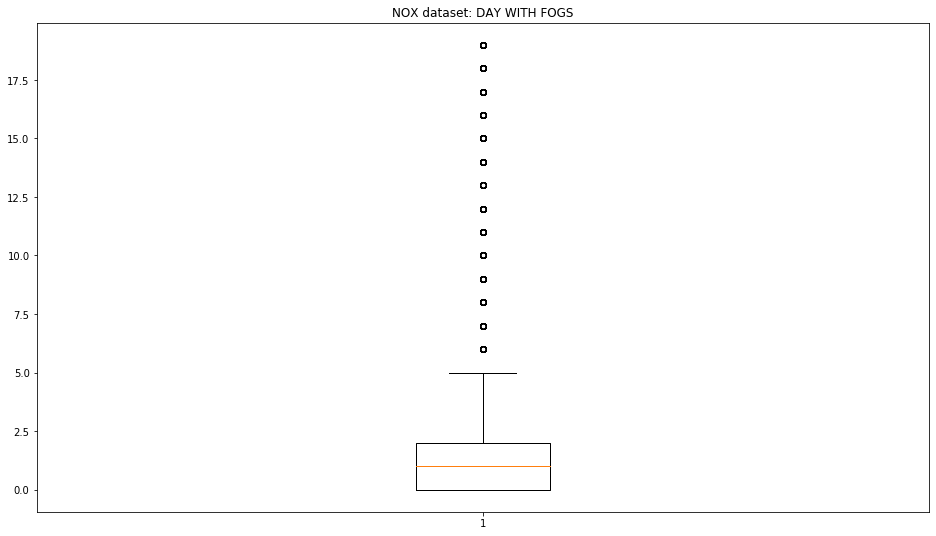

In [259]:
_plot(NOX_dt, "NOX")

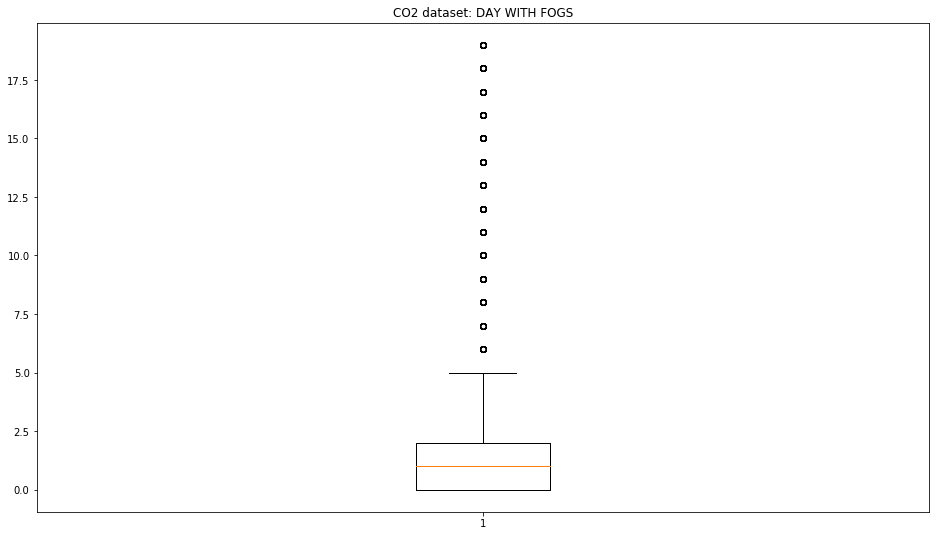

In [260]:
_plot(CO2_dt, "CO2")

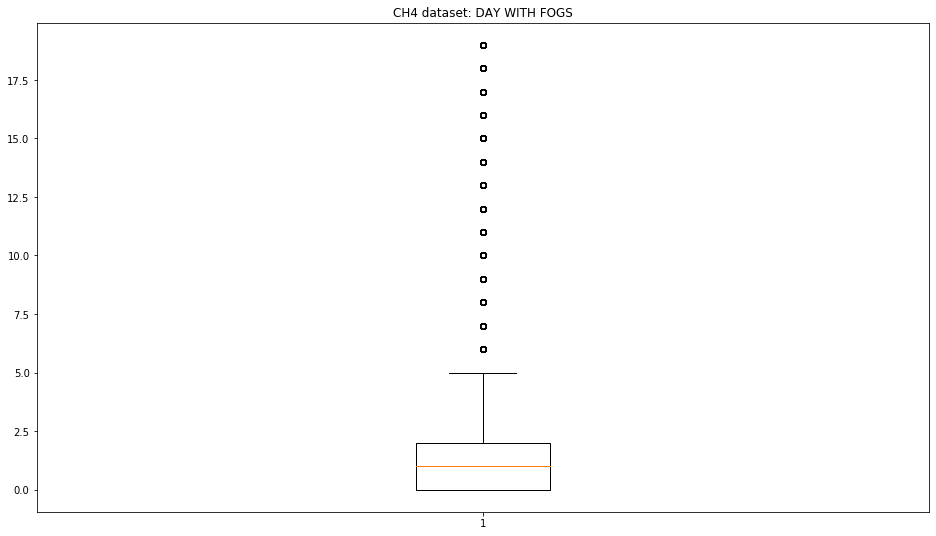

In [261]:
_plot(CH4_dt, "CH4")

In [262]:
def remove_out(data):
  """
  removes outliers over 5 IQR from the mean
  """
  data = data[(data["DAY WITH FOGS"] <= 5*iqr(data["DAY WITH FOGS"]))]
  return data

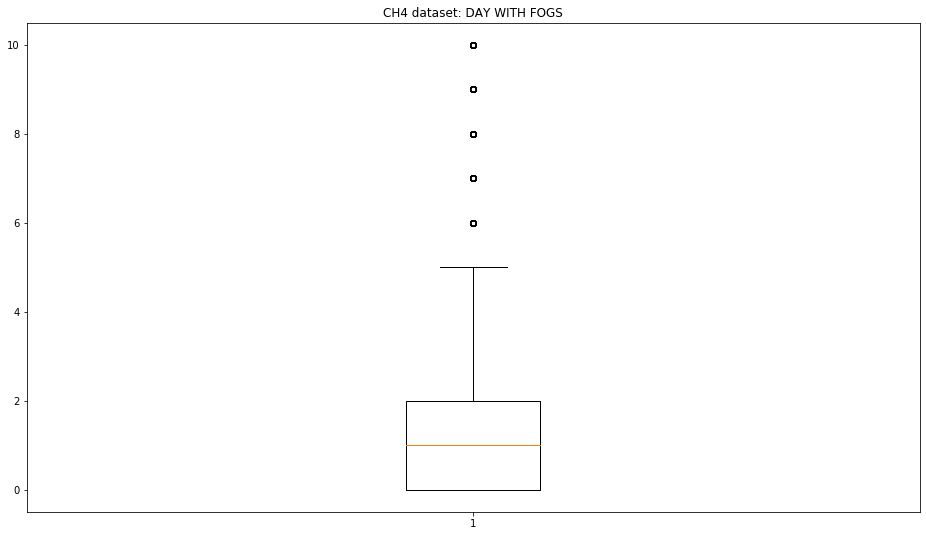

In [263]:
NOX_dt_ = remove_out(NOX_dt)
CO2_dt_ = remove_out(CO2_dt)
CH4_dt_ = remove_out(CH4_dt)

_plot(CH4_dt_, "CH4")

In [264]:
#Adding new column Target with value 0, 1, or 2
NOX_DT = NOX_dt_.copy(deep = True)
CO2_DT = CO2_dt_.copy(deep = True)
CH4_DT = CH4_dt_.copy(deep = True)
NOX_DT['Target'] = 0
CO2_DT["Target"] = 1
CH4_DT["Target"] = 2
# Appending datasets with the extra column
dt_ = NOX_DT.append(CO2_DT)[["City","EPRTRSectorCode", "DAY WITH FOGS", "EPRTRAnnexIMainActivityCode", "reportingYear", "MONTH", "countryName", "Target"]]
complete_dt = dt_.append(CH4_DT)[["City","EPRTRSectorCode", "DAY WITH FOGS", "EPRTRAnnexIMainActivityCode", "reportingYear", "MONTH", "countryName", "Target"]]

test_dataframe = test_dataframe[["test_index", "City", "EPRTRSectorCode", "DAY WITH FOGS", "EPRTRAnnexIMainActivityCode", "reportingYear", "MONTH", "countryName"]]

# Creating a new dataset
final_dataset = pd.DataFrame(complete_dt).reset_index(drop=True)

In [265]:
def unique_encode(df, column_name):
  """
  gets unique values in dataframe column and returns a dictionary
  {value: encoded value}
  """
  return {value: encoded for encoded, value in enumerate(df[column_name].unique())}


def encode(self, *column_names):
  """
  method that encodes the values of columns using a dictionary
  """
  for column_name in column_names:
    encode_dict = unique_encode(self, column_name)
    self.replace({column_name: encode_dict}, inplace=True)

pd.DataFrame.encode = encode

In [266]:
#city_dict = unique_encode(final_dataset, "City")
final_dataset.encode("City", "countryName", "EPRTRAnnexIMainActivityCode")

test_dataframe.encode("City", "countryName", "EPRTRAnnexIMainActivityCode")

In [267]:
final_dataset

,City,EPRTRSectorCode,DAY WITH FOGS,EPRTRAnnexIMainActivityCode,reportingYear,MONTH,countryName,Target
0,0,6.0,10,0,2015,12,0,0
1,1,1.0,0,1,2014,1,1,0
2,2,6.0,0,0,2014,6,2,0
3,3,1.0,2,2,2018,8,3,0
4,4,1.0,2,2,2014,2,4,0
...,...,...,...,...,...,...,...,...
26669,2996,1.0,7,2,2019,7,0,2
26670,3363,1.0,5,2,2019,9,0,2
26671,3593,5.0,2,12,2019,12,0,2
26672,4185,5.0,9,12,2019,10,0,2


In [268]:
final_dataset.corr()

,City,EPRTRSectorCode,DAY WITH FOGS,EPRTRAnnexIMainActivityCode,reportingYear,MONTH,countryName,Target
City,1.000000,0.387232,0.017925,0.233189,0.022408,-0.019618,0.018440,0.548923
EPRTRSectorCode,0.387232,1.000000,-0.028913,0.559925,0.040478,-0.001209,0.027849,0.344257
DAY WITH FOGS,0.017925,-0.028913,1.000000,-0.066005,0.001561,-0.005510,-0.237723,0.059152
EPRTRAnnexIMainActivityCode,0.233189,0.559925,-0.066005,1.000000,0.034918,-0.004170,0.073314,0.219080
reportingYear,0.022408,0.040478,0.001561,0.034918,1.000000,0.013674,0.034426,0.021577
MONTH,-0.019618,-0.001209,-0.005510,-0.004170,0.013674,1.000000,-0.002896,-0.010745
countryName,0.018440,0.027849,-0.237723,0.073314,0.034426,-0.002896,1.000000,0.001503
Target,0.548923,0.344257,0.059152,0.219080,0.021577,-0.010745,0.001503,1.000000


In [269]:
final_dataset = final_dataset[["City", "EPRTRSectorCode", "EPRTRAnnexIMainActivityCode", "Target"]]

test_dataframe = test_dataframe[["test_index", "City", "EPRTRSectorCode", "EPRTRAnnexIMainActivityCode"]]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24480 entries, 0 to 24479
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   test_index                   24480 non-null  int64
 1   City                         24480 non-null  int64
 2   EPRTRSectorCode              24480 non-null  int64
 3   DAY WITH FOGS                24480 non-null  int64
 4   EPRTRAnnexIMainActivityCode  24480 non-null  int64
 5   reportingYear                24480 non-null  int64
 6   MONTH                        24480 non-null  int64
 7   countryName                  24480 non-null  int64
dtypes: int64(8)
memory usage: 1.7 MB


In [270]:
test_data = final_dataset[["City", "EPRTRSectorCode", "EPRTRAnnexIMainActivityCode"]]

In [271]:
X_train, X_test, y_train, y_test= train_test_split (final_dataset.iloc[:,:-1], final_dataset.iloc[:,-1], test_size=0.2, random_state=42) 

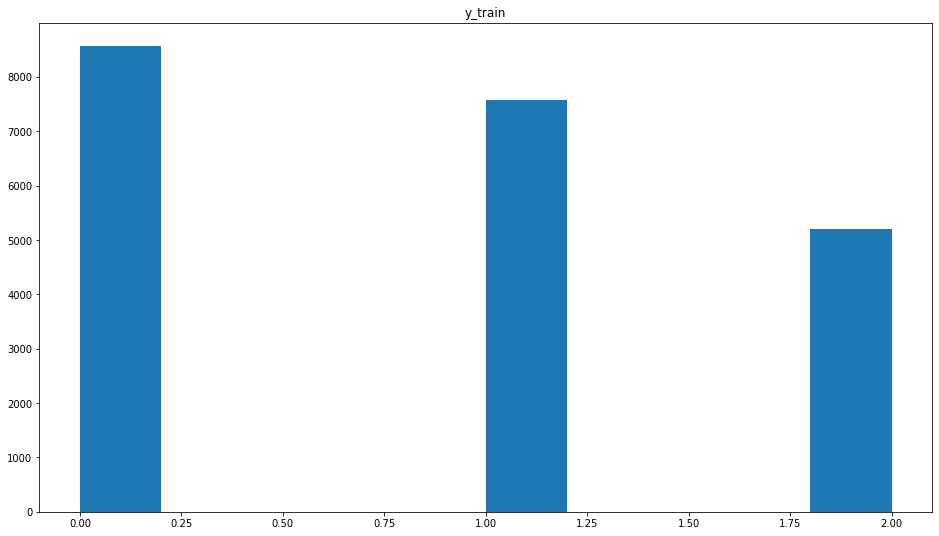

In [272]:
# Histogram y_train 
plt.hist(y_train)
plt.title("y_train")
plt.show()

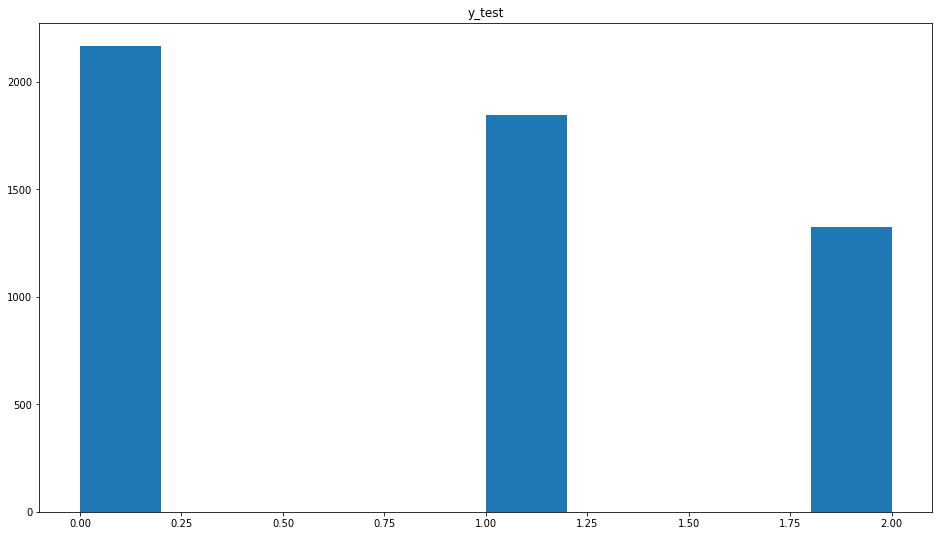

In [273]:
# Histogram y_test 
plt.hist(y_test)
plt.title("y_test")
plt.show()

In [274]:
def multi_model_predict(models, X_train, y_train, X_test, y_test):
    """
    use multiple models to fit the data. Return the best one
    """
    score_inner = 0
    best_model_inner = ""
    
    for name, model in models.items():
        model.fit(X_train, y_train)

        print(f"\033[94;1m{name} model statistics:{white}".center(53, "-"))

        print(f"\n\n{blue}RESULTS TEST DATASET{white}\n")

        # Prediction values based on testing dataset
        y_pred = model.predict(X_test)

        # Confusion matrix based on real classes and predictes ones
        matrix = confusion_matrix(y_test, y_pred)

        # Accuracy of model
        result = model.score(X_test, y_test)

        # Report of model
        dict_report = classification_report(y_test, y_pred, output_dict = True)
        report = classification_report(y_test, y_pred)

        f_score = dict_report["accuracy"]

        print(f'{red}{f_score}{white}\n')

        # if f score of current model is better than current score, store
        # the name of the model and the score
        if f_score > score_inner:
            score_inner = f_score
            best_model_inner = name

        ### PRINT INFO
        print(f"{blue}Confusion matrix:{white}\n{matrix}\n")
        print(f"{blue}{name} Model Accuracy:{white} {result}\n")
        print(f"{report}\n")

        print(f"{blue}RESULTS TRAINING  DATASET{white}\n")

        # Prediction values based on training dataset
        y_pred_train = model.predict(X_train) 

        # Confusion matrix based on real classes and predictes ones
        matrix = confusion_matrix(y_train, y_pred_train)

        # Accuracy of model
        result = model.score(X_train, y_train) 

        # Report of model
        report = classification_report(y_train,y_pred_train)

        ### PRINT INFO
        print(f"{blue}Confusion matrix:{white}\n{matrix}\n")
        print(f"{blue}{name} Model Accuracy:{white} {result}\n")
        print(f"{report}\n")
    return score, best_model

In [275]:
scikit_models = {"SVC": SVC(),
                 "Decision tree": DecisionTreeClassifier(),
                 "Random forest": RandomForestClassifier(),
                 "Gradient boosting":GradientBoostingClassifier()}

scikit_models["Voting ensemble"] = VotingClassifier(estimators=[name_model_pair for name_model_pair in scikit_models.items()], voting='hard')

best_score, best_model = multi_model_predict(scikit_models, X_train, y_train, X_test, y_test)


-----------SVC model statistics:----------


RESULTS TEST DATASET

0.5932521087160263

Confusion matrix:
[[2109   57    0]
 [1632  190   24]
 [ 397   60  866]]

SVC Model Accuracy: 0.5932521087160263

              precision    recall  f1-score   support

           0       0.51      0.97      0.67      2166
           1       0.62      0.10      0.18      1846
           2       0.97      0.65      0.78      1323

    accuracy                           0.59      5335
   macro avg       0.70      0.58      0.54      5335
weighted avg       0.66      0.59      0.53      5335


RESULTS TRAINING  DATASET

Confusion matrix:
[[8300  268    0]
 [6691  805   81]
 [1576  201 3417]]

SVC Model Accuracy: 0.5868128778293266

              precision    recall  f1-score   support

           0       0.50      0.97      0.66      8568
           1       0.63      0.11      0.18      7577
           2       0.98      0.66      0.79      5194

    accuracy                           0.59     21339
   m

In [276]:
print(f'Best model: {best_model}\nScore: {best_score}')

Best model: Gradient boosting
Score: 0.6617233444131936


In [277]:
NOX_dt_s = final_dataset[final_dataset["Target"]==0]
CO2_dt_s = final_dataset[final_dataset["Target"]==1]
CH4_dt_s = final_dataset[final_dataset["Target"]==2]

print("The length of NOX_dt_s is:", len(NOX_dt_s))
print("The length of CO2_dt_s is:", len(CO2_dt_s))
print("The length of CH4_dt_s is:", len(CH4_dt_s))

The length of NOX_dt_s is: 10734
The length of CO2_dt_s is: 9423
The length of CH4_dt_s is: 6517


In [278]:
#undersampling
NOX_dt_s_sample=NOX_dt_s.sample(6517)
CO2_dt_s_sample=CO2_dt_s.sample(6517)
print("The new number of samples in noncustomer dataset is:", len(NOX_dt_s_sample))
print("The new number of samples in noncustomer dataset is:", len(CO2_dt_s_sample))

The new number of samples in noncustomer dataset is: 6517
The new number of samples in noncustomer dataset is: 6517


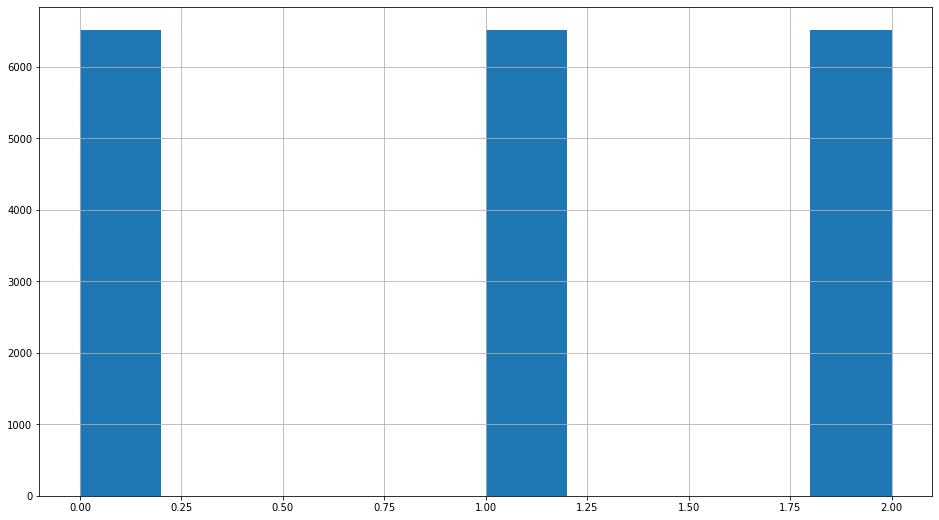

In [279]:
dt_=NOX_dt_s_sample.append(CO2_dt_s_sample).reset_index().drop('index', axis=1)
final_dataset_= dt_.append(CH4_dt_s).reset_index().drop('index', axis=1)
final_dataset_=final_dataset_.loc[:,["City", "EPRTRSectorCode", "EPRTRAnnexIMainActivityCode", "Target"]]
final_dataset_.Target.hist()

In [280]:
X_train, X_test, y_train, y_test= train_test_split (final_dataset_.iloc[:,:-1], final_dataset_.iloc[:,-1], test_size=0.2, random_state=42) 

In [281]:
best_score, best_model = multi_model_predict(scikit_models, X_train, y_train, X_test, y_test)

-----------SVC model statistics:----------


RESULTS TEST DATASET

0.5747890565072872

Confusion matrix:
[[1243   47    0]
 [1143  131   29]
 [ 382   62  874]]

SVC Model Accuracy: 0.5747890565072872

              precision    recall  f1-score   support

           0       0.45      0.96      0.61      1290
           1       0.55      0.10      0.17      1303
           2       0.97      0.66      0.79      1318

    accuracy                           0.57      3911
   macro avg       0.65      0.58      0.52      3911
weighted avg       0.66      0.57      0.52      3911


RESULTS TRAINING  DATASET

Confusion matrix:
[[4983  244    0]
 [4487  596  131]
 [1552  225 3422]]

SVC Model Accuracy: 0.5755115089514067

              precision    recall  f1-score   support

           0       0.45      0.95      0.61      5227
           1       0.56      0.11      0.19      5214
           2       0.96      0.66      0.78      5199

    accuracy                           0.58     15640
   m

In [282]:
print(f'Best model: {best_model}\nScore: {best_score}')

Best model: Gradient boosting
Score: 0.6617233444131936


In [298]:
test_dataframe = test_dataframe[["test_index", "City", "EPRTRSectorCode", "EPRTRAnnexIMainActivityCode"]]

final_y_pred = scikit_models[best_model].predict(test_dataframe[["City", "EPRTRSectorCode", "EPRTRAnnexIMainActivityCode"]])


y_series = pd.Series(final_y_pred)


cols = ['test_index','pollutant']
list_of_series = [test_dataframe['test_index'], y_series]
prediction_dataframe = pd.DataFrame(list_of_series, index=cols).transpose()

with open(f'{CWD}/predictions.csv', "w") as file:
    prediction_dataframe.to_csv(file)
    
with open(f'{CWD}/predictions.json', "w") as file:
    prediction_dataframe.to_json(file)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24480 entries, 0 to 24479
Data columns (total 4 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   test_index                   24480 non-null  int64
 1   City                         24480 non-null  int64
 2   EPRTRSectorCode              24480 non-null  int64
 3   EPRTRAnnexIMainActivityCode  24480 non-null  int64
dtypes: int64(4)
memory usage: 1.6 MB
